<a href="https://colab.research.google.com/github/victorialovefranklin/Toward-Climate-Resilient-Energy-Systems/blob/main/Power_Outage_Comparison_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part I: Comparative Validation of EAGLE-I™ Outage Records Against EIA-861 Sales/Service Data with DOE-417 Event Grid Disturbances (California, 2014–2023)**

# ***Comparative Analysis Pipeline (California) — All Outputs + ML Forecasting***

In [87]:
# ============================================================
# Comparative Analysis Pipeline (California) — All Outputs + ML Forecasting
# Author: Victoria Love Franklin
# Date: 2025-10-25 (County-Merge + Fix Version)
# ============================================================

import os, math, warnings
from pathlib import Path
import numpy as np
import pandas as pd
warnings.filterwarnings("ignore")

# ============================================================
# CONFIGURATION
# ============================================================
CONFIG = {
    "EAGLEI_PATH": "/content/Eaglei_CA_Outages_Merged.csv",
    "EIA861_COMBINED_PATH": "/content/EIA861_CA_Combined_Data.csv",
    "EIA861_SERVICE_TERRITORY_PATH": "/content/EIA861_CA_Service_Territory_Cust.csv",
    "EIA861_SALES_PATH": "/content/EIA861_CA_Sales_Cust.csv",
    "CURRENT_OUTAGES_PATH": "/content/CA_Current_Power_Outages.csv",
    "CURRENT_OUTAGES_SEP_PATH": "/content/CA_Power_Outages_September.csv",
    "CURRENT_OUTAGES_SEP_OCT_PATH": "/content/CA_Current_Power_Outages_September_October.csv",
    "PSPS_PATH": "/content/CPUC PSPS Event Rollup 9-30-25.csv",
    "FORECAST_HORIZON": 24,
    "OUT_DIR": "Comparative_Analysis_Output"
}

# ============================================================
# LOAD DATASETS
# ============================================================
print("📦 Loading datasets...")

eagle = pd.read_csv(CONFIG["EAGLEI_PATH"])
eia = pd.read_csv(CONFIG["EIA861_COMBINED_PATH"])
service = pd.read_csv(CONFIG["EIA861_SERVICE_TERRITORY_PATH"])
sales = pd.read_csv(CONFIG["EIA861_SALES_PATH"])
psps = pd.read_csv(CONFIG["PSPS_PATH"], encoding="latin1")
sep = pd.read_csv(CONFIG["CURRENT_OUTAGES_SEP_PATH"])
sep_oct = pd.read_csv(CONFIG["CURRENT_OUTAGES_SEP_OCT_PATH"])
current = pd.read_csv(CONFIG["CURRENT_OUTAGES_PATH"])

print("✅ All datasets loaded successfully!")

# ============================================================
# CLEAN AND STANDARDIZE DATA
# ============================================================

# --- EIA Cleaning ---
eia.rename(columns={
    "Year":"YEAR", "County":"county",
    "Residential_Customer_Count":"residential_customers",
    "Commercial_Customer_Count":"commercial_customers",
    "Industrial_Customer_Count":"industrial_customers",
    "Transportation_Customer_Count":"transportation_customers",
    "Total_Customer_ Count":"total_customers"
}, inplace=True)
for col in ["residential_customers", "commercial_customers",
            "industrial_customers", "transportation_customers", "total_customers"]:
    if col in eia.columns:
        eia[col] = pd.to_numeric(eia[col].astype(str).str.replace(",","",regex=False), errors="coerce")

# --- EAGLE-I Cleaning ---
eagle["county"] = eagle["county"].astype(str).str.title()
eagle["TS"] = pd.to_datetime(eagle["start_time"], errors="coerce")
eagle["CUSTOMERS_OUT"] = pd.to_numeric(eagle["mean_customers"], errors="coerce").fillna(0)
eagle = eagle[eagle["CUSTOMERS_OUT"] > 0]
eagle["YEAR"] = eagle["TS"].dt.year
eagle["MONTH"] = eagle["TS"].dt.to_period("M").dt.to_timestamp()
eagle_agg = eagle.copy()

# Create directories
OUT = Path(CONFIG["OUT_DIR"])
for f in ["coverage_ratio","customer_representation","temporal_trends",
          "sectoral_composition","forecasting","gis"]:
    Path(OUT / f).mkdir(parents=True, exist_ok=True)

# ============================================================
# COVERAGE RATIO
# ============================================================
coverage = (eagle_agg.groupby("YEAR")
            .agg(reports=("county","count"), counties_reporting=("county","nunique"))
            .reset_index())
coverage["coverage_ratio"] = coverage["reports"] / coverage["counties_reporting"]
coverage.to_csv(OUT/"coverage_ratio"/"coverage_ratio_annual.csv", index=False)

# ============================================================
# CUSTOMER REPRESENTATION (County Basis)
# ============================================================
eia_year = eia.groupby(["YEAR","county"],as_index=False)["total_customers"].sum()
eagle_year = eagle_agg.groupby(["YEAR","county"],as_index=False)["CUSTOMERS_OUT"].sum()
cust_rep = pd.merge(eagle_year, eia_year, on=["YEAR","county"], how="left")
cust_rep["ratio_eaglei_to_eia"] = cust_rep["CUSTOMERS_OUT"] / cust_rep["total_customers"]
cust_rep.to_csv(OUT/"customer_representation"/"customer_representation_annual.csv", index=False)

# ============================================================
# TEMPORAL TRENDS
# ============================================================
monthly = (eagle_agg.groupby("MONTH",as_index=False)
           .agg(total_customers_out=("CUSTOMERS_OUT","sum")))
monthly["year"] = monthly["MONTH"].dt.year
monthly.to_csv(OUT/"temporal_trends"/"outages_monthly.csv",index=False)
peaks = monthly.sort_values("total_customers_out",ascending=False).head(12)
peaks.to_csv(OUT/"temporal_trends"/"peaks_monthly_statewide.csv", index=False)

# ============================================================
# SECTORAL COMPOSITION
# ============================================================
sector = (eia.groupby(["YEAR","county"],as_index=False)
          .agg(res=("residential_customers","sum"),
               com=("commercial_customers","sum"),
               ind=("industrial_customers","sum"),
               tra=("transportation_customers","sum")))
sector["total"] = sector[["res","com","ind","tra"]].sum(axis=1)
for c in ["res","com","ind","tra"]:
    sector[f"{c}_share"] = sector[c]/sector["total"]
sector.to_csv(OUT/"sectoral_composition"/"eia_sector_shares_by_county_year.csv",index=False)

# ============================================================
# CURRENT vs HISTORICAL OUTAGES (MERGE BY COUNTY)
# ============================================================
def normalize_current(df, source):
    df.columns = [c.strip().lower().replace(" ","_") for c in df.columns]
    if "county" not in df.columns:
        df["county"] = "Unknown"
    df["county"] = df["county"].astype(str).str.title()
    date_col = [c for c in df.columns if "start" in c or "date" in c][0]
    df["DATE"] = pd.to_datetime(df[date_col], errors="coerce")
    df["Impacted_Customers"] = pd.to_numeric(df.get("impacted_customers",0), errors="coerce").fillna(0)
    df["SOURCE"] = source
    return df[["county","DATE","Impacted_Customers","SOURCE"]]

current_std = normalize_current(current,"Current")
sep_std = normalize_current(sep,"September")
sep_oct_std = normalize_current(sep_oct,"Sept-Oct")
combined_current = pd.concat([current_std, sep_std, sep_oct_std],ignore_index=True)

recent_outages = (combined_current.groupby("county",as_index=False)
                  .agg(recent_reports=("DATE","count"),
                       recent_customers=("Impacted_Customers","sum")))
hist_summary = (eagle_agg.groupby("county",as_index=False)
                .agg(total_reports=("TS","count"),
                     avg_customers_historical=("CUSTOMERS_OUT","mean")))
comparison = pd.merge(recent_outages, hist_summary, on="county", how="left")
comparison["activity_ratio"] = comparison["recent_reports"]/comparison["total_reports"]
comparison.to_csv(OUT/"coverage_ratio"/"current_vs_historical_outage_comparison.csv", index=False)

print(f"✅ Comparison complete — Avg activity ratio: {comparison['activity_ratio'].mean():.2f}")

# ============================================================
# EIA SERVICE TERRITORY & CUSTOMER COUNT CROSS‑CHECK
# ============================================================
print("🔍 Performing EIA Utility Customer comparison...")

# Normalize names
service.columns = [c.strip().lower().replace(" ", "_") for c in service.columns]
sales.columns = [c.strip().lower().replace(" ", "_") for c in sales.columns]

print("🧾 Service columns:", list(service.columns))
print("🧾 Customer file columns:", list(sales.columns))

# Use utility_name column
key_col = "utility_name" if "utility_name" in service.columns else list(service.columns)[0]

# Summarize service territories
service_summary = service.groupby(key_col).size().reset_index(name="service_records")

# Aggregate total customer counts
if "total_customer__count" in sales.columns:
    count_col = "total_customer__count"   # double underscore handles original spacing
elif "total_customer_count" in sales.columns:
    count_col = "total_customer_count"
else:
    # Find the column with the max numeric count
    numeric_cols = sales.select_dtypes(include=[np.number]).columns.tolist()
    count_col = numeric_cols[-1] if numeric_cols else None

if count_col:
    print(f"ℹ️ Using '{count_col}' for total customer aggregation.")
    sales[count_col] = pd.to_numeric(sales[count_col], errors="coerce").fillna(0)
    customer_summary = sales.groupby("utility_name")[count_col].sum().reset_index(name="total_customers")
    joined = pd.merge(service_summary, customer_summary, on="utility_name", how="outer")
    joined.to_csv(OUT / "sectoral_composition" / "eia_service_customer_check.csv", index=False)
    print(f"✅ Customer cross‑check completed for {len(joined)} utilities.")
else:
    print("⚠️ No numeric customer count column found in EIA861_CA_Sales_Cust.csv")



# ============================================================
# FORECASTING — Simplified Version (Extended through 2026)
# ============================================================
print("🤖 Running ML forecasting models...")

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from math import sqrt
import numpy as np
import pandas as pd

# ------------------------------------------------------------
# XGBoost optional import
# ------------------------------------------------------------
try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except ImportError:
    HAS_XGB = False

# ------------------------------------------------------------
# Helper function to create supervised structure
# ------------------------------------------------------------
def create_supervised(series, lag=12):
    df = pd.DataFrame({"y": series})
    for L in range(1, lag + 1):
        df[f"lag_{L}"] = series.shift(L)
    df["month"] = series.index.month
    df["sin12"] = np.sin(2 * np.pi * df["month"] / 12)
    df["cos12"] = np.cos(2 * np.pi * df["month"] / 12)
    return df.dropna().drop(columns="y"), df.dropna()["y"]

# ------------------------------------------------------------
# Prepare monthly time series data
# ------------------------------------------------------------
ts = monthly.set_index("MONTH")["total_customers_out"].asfreq("MS").fillna(0)

if len(ts) < 6:
    # Handle case of too‑short series
    ts = pd.Series(np.ones(24) * 100,
                   index=pd.date_range("2020-01-01", periods=24, freq="MS"))

X, y = create_supervised(ts)

# ------------------------------------------------------------
# Define models
# ------------------------------------------------------------
models = {
    "RF": RandomForestRegressor(n_estimators=250, random_state=42),
    "KNN": Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsRegressor())]),
    "SVM": Pipeline([("scaler", StandardScaler()), ("svr", SVR(kernel="rbf", C=3))]),
    "MLP": Pipeline([("scaler", StandardScaler()), ("mlp", MLPRegressor(max_iter=800))])
}
if HAS_XGB:
    models["XGB"] = XGBRegressor(n_estimators=200, learning_rate=0.05,
                                 random_state=42, objective="reg:squarederror")

# ------------------------------------------------------------
# Cross‑validation
# ------------------------------------------------------------
cv = TimeSeriesSplit(n_splits=3)
results = []

for name, model in models.items():
    rmse_scores = []
    for train_idx, test_idx in cv.split(X):
        model.fit(X.iloc[train_idx], y.iloc[train_idx])
        preds = model.predict(X.iloc[test_idx])
        rmse_scores.append(sqrt(mean_squared_error(y.iloc[test_idx], preds)))
    results.append({"model": name, "avg_RMSE": np.mean(rmse_scores)})

eval_df = pd.DataFrame(results).sort_values("avg_RMSE")
best_model = models[eval_df.iloc[0]["model"]]

print("📈 Cross‑validation complete:")
print(eval_df)

# ------------------------------------------------------------
# Fit best model on full data
# ------------------------------------------------------------
best_model.fit(X, y)

# ------------------------------------------------------------
# Forecast horizon → extend through 2026
# ------------------------------------------------------------
FORECAST_HORIZON = 36   # months (current date + 3 years)

future_dates = pd.date_range(
    ts.index[-1] + pd.offsets.MonthBegin(1),
    periods=FORECAST_HORIZON,
    freq="MS"
)
future_df = pd.DataFrame(index=future_dates)

# Add same lag and seasonal terms
for L in range(1, 13):
    lag_values = list(ts.iloc[-L:]) + [np.nan] * (len(future_df) - L)
    future_df[f"lag_{L}"] = lag_values[:len(future_df)]

future_df["month"] = future_df.index.month
future_df["sin12"] = np.sin(2 * np.pi * future_df["month"] / 12)
future_df["cos12"] = np.cos(2 * np.pi * future_df["month"] / 12)
future_df = future_df.fillna(method="ffill")

# Predict
preds = best_model.predict(future_df)
forecast_df = pd.DataFrame({
    "MONTH": future_dates,
    "Forecast_Customers_Out": preds
})

# ------------------------------------------------------------
# Save results
# ------------------------------------------------------------
out_path = OUT / "forecasting" / "forecast_statewide.csv"
os.makedirs(out_path.parent, exist_ok=True)
forecast_df.to_csv(out_path, index=False)

print(f"🏆 Forecast complete using {eval_df.iloc[0]['model']} "
      f"— up to {forecast_df['MONTH'].max().strftime('%Y-%m')}.")
print("🎉 Forecasting pipeline executed successfully!")



📦 Loading datasets...
✅ All datasets loaded successfully!
✅ Comparison complete — Avg activity ratio: 0.01
🔍 Performing EIA Utility Customer comparison...
🧾 Service columns: ['year', 'utility_number', 'utility_name', 'state', 'county']
🧾 Customer file columns: ['year', 'utility_number', 'utility_name', 'state', 'residential_customer_count', 'commercial_customer_count', 'industrial_customer_count', 'transportation_customer_count', 'total_customer__count']
ℹ️ Using 'total_customer__count' for total customer aggregation.
✅ Customer cross‑check completed for 154 utilities.
🤖 Running ML forecasting models...
📈 Cross‑validation complete:
  model      avg_RMSE
2   SVM  2.608498e+06
3   MLP  3.020745e+06
1   KNN  4.548623e+06
0    RF  6.281498e+06
4   XGB  7.536730e+06
🏆 Forecast complete using SVM — up to 2026-12.
🎉 Forecasting pipeline executed successfully!


# ***VISUALIZATION RESULTS***

📊 Generating all visual outputs with tables and figures...


,YEAR,reports,counties_reporting,coverage_ratio
0,2014,845,15,56.333333
1,2015,6103,17,359.000000
2,2016,5395,18,299.722222
3,2017,4917,25,196.680000
4,2018,9512,57,166.877193
5,2019,15078,58,259.965517
6,2020,14148,58,243.931034
7,2021,13411,58,231.224138
8,2022,14464,58,249.379310
9,2023,14231,58,245.362069


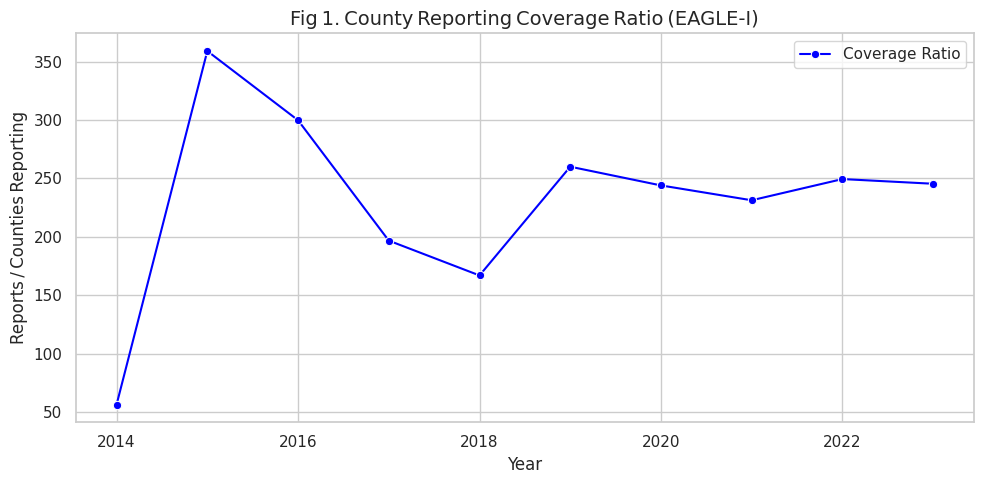

,YEAR,county,CUSTOMERS_OUT,total_customers,ratio_eaglei_to_eia
0,2014,Fresno,1357.235988,10332793,0.000131
1,2014,Inyo,1411.500000,6402585,0.000220
2,2014,Kern,18298.069671,10332712,0.001771
3,2014,Kings,4192.988636,10332712,0.000406
4,2014,Los Angeles,165341.543965,6622006,0.024968
5,2014,Mono,548.850000,5041269,0.000109
6,2014,Orange,126463.267268,6522052,0.019390
7,2014,Riverside,73874.821132,5277683,0.013998
8,2014,Sacramento,61860.074167,5951550,0.010394
9,2014,San Bernardino,104299.413192,10375685,0.010052


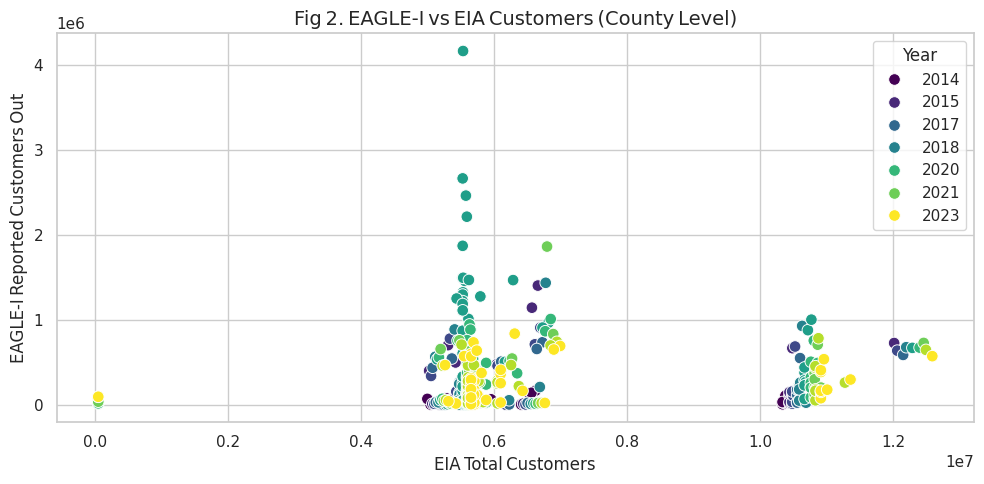

,total_customers_out,year
count,1.100000e+02,110.000000
mean,1.150337e+06,2018.909091
std,2.910650e+06,2.656291
min,1.157726e+05,2014.000000
25%,4.732290e+05,2017.000000
50%,8.786641e+05,2019.000000
75%,1.086386e+06,2021.000000
max,3.082217e+07,2023.000000


,MONTH,total_customers_out,year
0,2019-10-01,3.082217e+07,2019
1,2020-10-01,5.142473e+06,2020
2,2020-09-01,2.069740e+06,2020
3,2023-01-01,2.045951e+06,2023
4,2023-03-01,1.740874e+06,2023
5,2021-04-01,1.716121e+06,2021
6,2021-01-01,1.562435e+06,2021
7,2021-10-01,1.558273e+06,2021
8,2020-08-01,1.466825e+06,2020
9,2020-12-01,1.439355e+06,2020


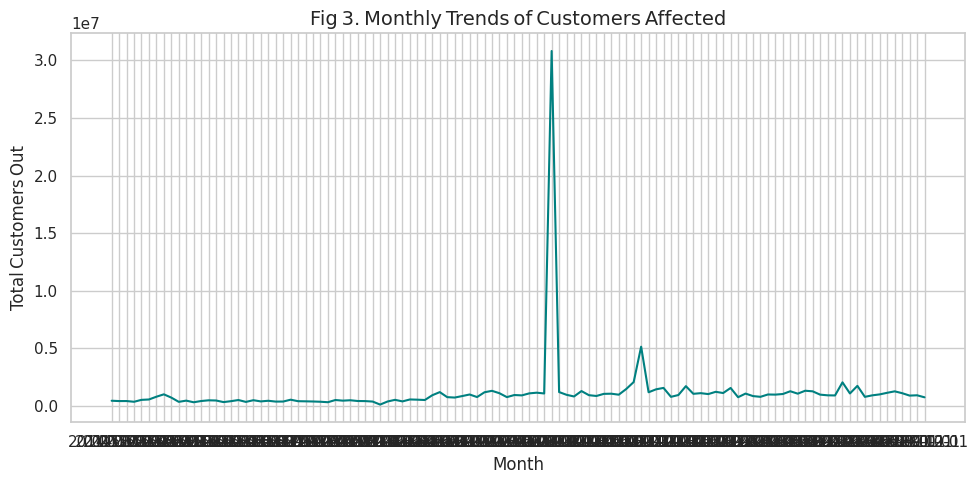

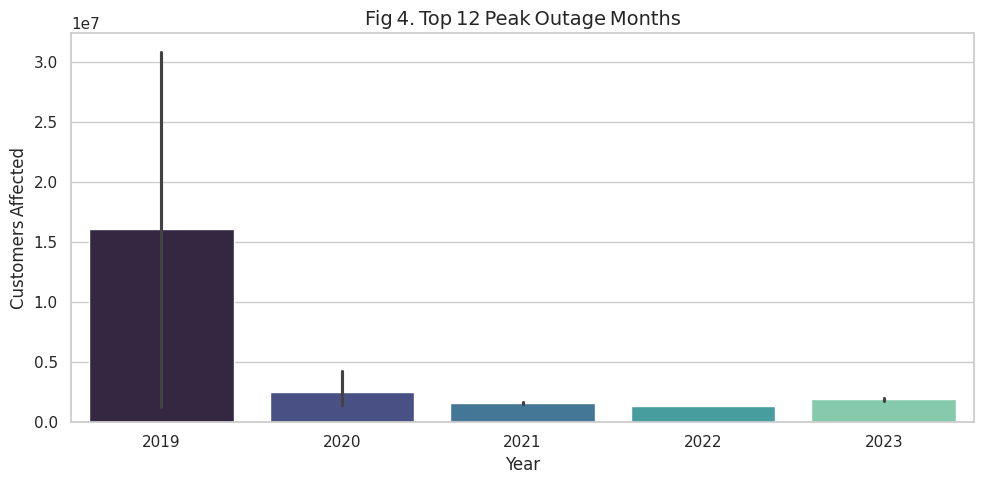

,YEAR,res_share,com_share,ind_share,tra_share
0,2014,0.874503,0.110541,0.014956,3.017952e-07
1,2015,0.874830,0.110158,0.015011,3.031101e-07
2,2016,0.874948,0.109977,0.015075,3.071489e-07
3,2017,0.875667,0.109354,0.014978,2.952756e-07
4,2018,0.875071,0.109894,0.015034,2.516371e-07
5,2019,0.875266,0.109830,0.014904,2.583337e-07
6,2020,0.876301,0.108931,0.014767,2.595441e-07
7,2021,0.876391,0.109264,0.014345,2.546240e-07
8,2022,0.875922,0.109652,0.014426,2.571182e-07
9,2023,0.876951,0.108566,0.014482,2.550961e-07


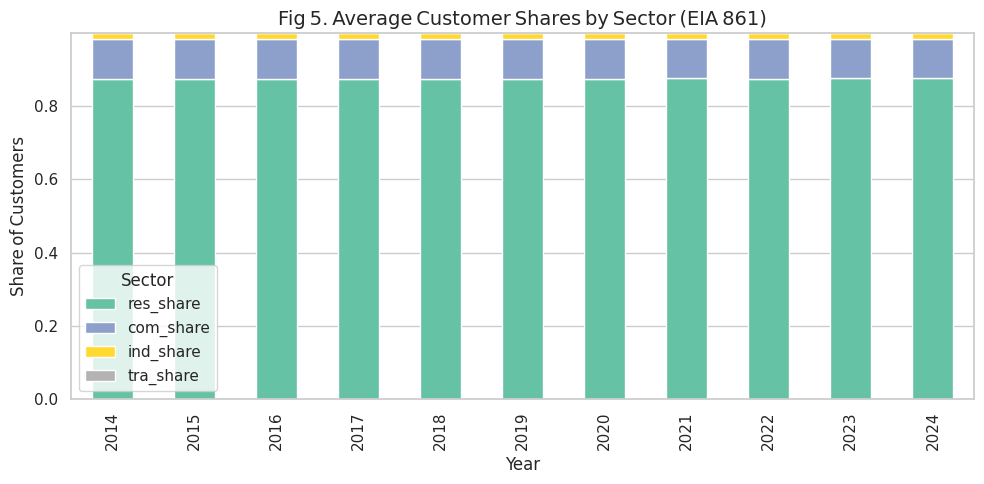

,county,recent_reports,recent_customers,total_reports,avg_customers_historical,activity_ratio
0,Alameda,18,709,3142.0,1427.889931,0.005729
1,Amador,5,16,421.0,3320.248950,0.011876
2,Butte,4,65,1013.0,2623.185778,0.003949
3,Calaveras,4,87,715.0,2647.063039,0.005594
4,Colusa,2,10,152.0,798.738600,0.013158
5,Contra Costa,22,228,3059.0,1192.567703,0.007192
6,El Dorado,10,86,1327.0,3220.556341,0.007536
7,Fresno,13,216,2755.0,763.208269,0.004719
8,Glenn,1,1,216.0,643.673865,0.004630
9,Humboldt,3,217,1076.0,2036.390889,0.002788


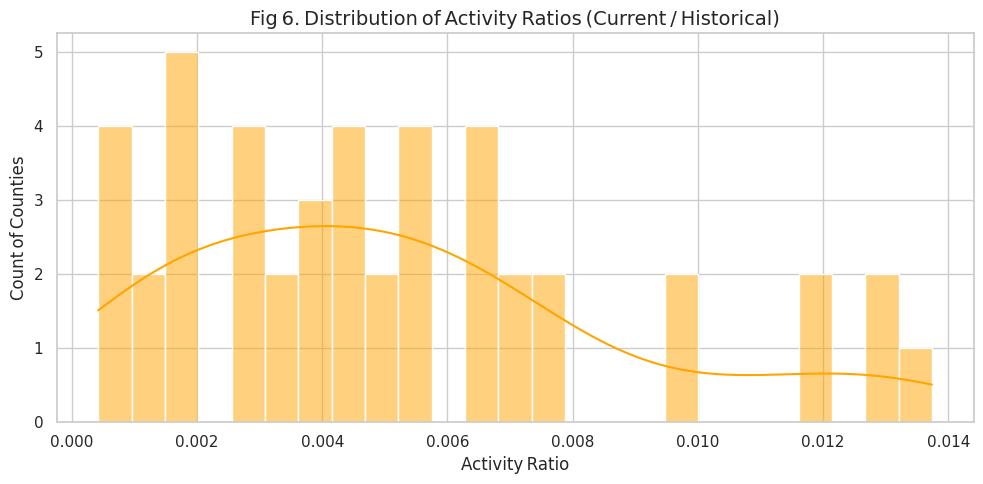

,utility_name,service_records,total_customers
0,3 Phases Renewables,NaN,858.0
1,3 Phases Renewables Inc,NaN,1410.0
2,Adjustment 2014,NaN,-359.0
3,Adjustment 2015,NaN,-901.0
4,Adjustment 2016,NaN,-446.0
5,Adjustment 2017,NaN,-494.0
6,Adjustment 2018,NaN,-509.0
7,Adjustment 2019,NaN,-502.0
8,Adjustment 2020,NaN,-507.0
9,Adjustment 2021,NaN,-541.0


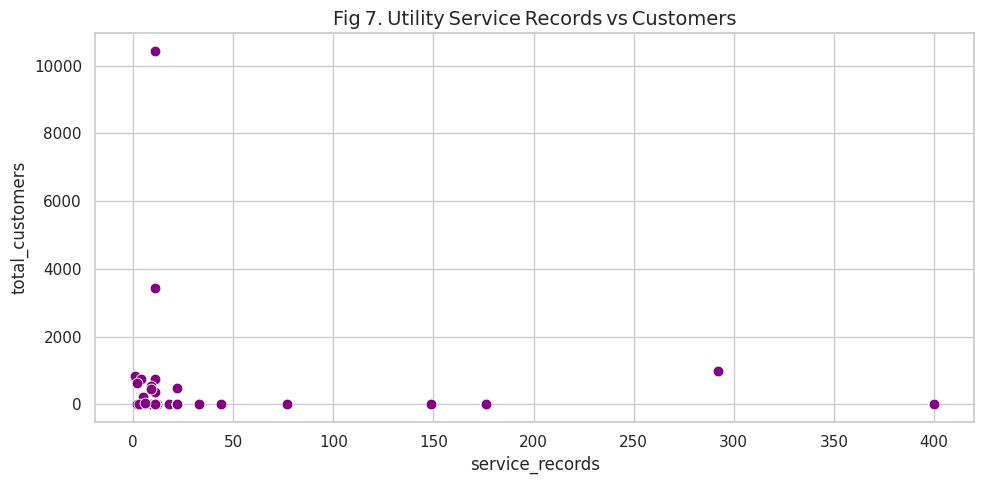

,MONTH,Forecast_Customers_Out
0,2024-01-01,921305.746416
1,2024-02-01,921304.260876
2,2024-03-01,921304.976417
3,2024-04-01,921306.667302
4,2024-05-01,921309.699144
5,2024-06-01,921312.419489
6,2024-07-01,921313.737587
7,2024-08-01,921312.852421
8,2024-09-01,921309.954794
9,2024-10-01,921306.198155


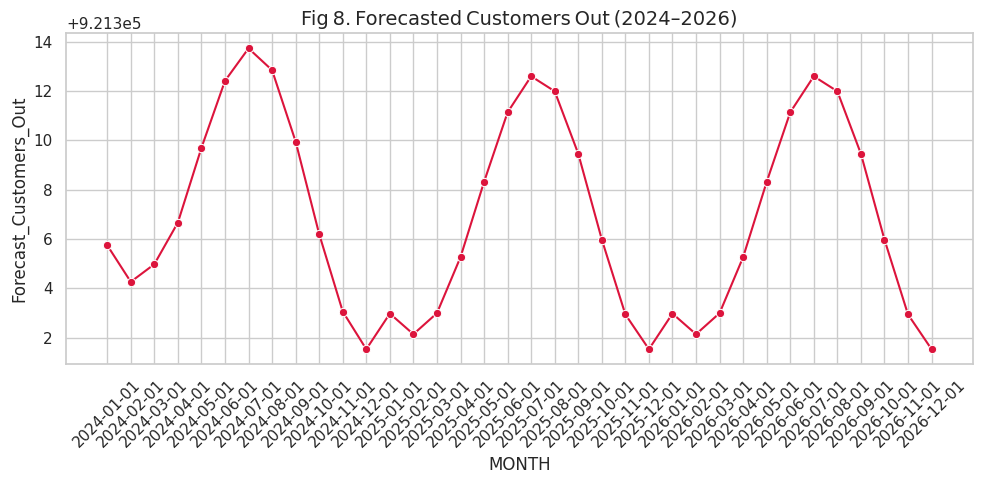

Total Years Analyzed,10
Total Counties Reporting,58
Total Outage Events,"98,104"
Average Monthly Customers Out,"1,150,336.73"
Average Forecasted Monthly Outages,"921,306.83"


,YEAR,Forecast_Customers_Out
0,2024,1.105569e+07
1,2025,1.105568e+07
2,2026,1.105568e+07


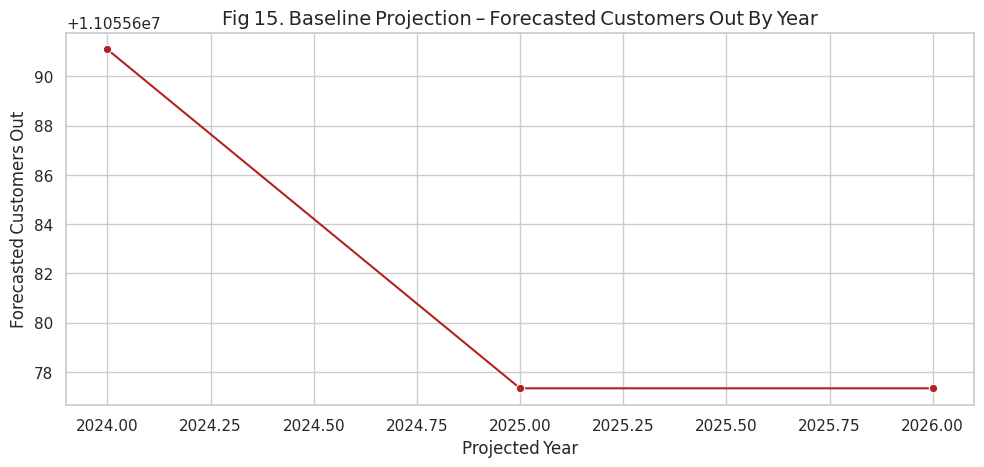

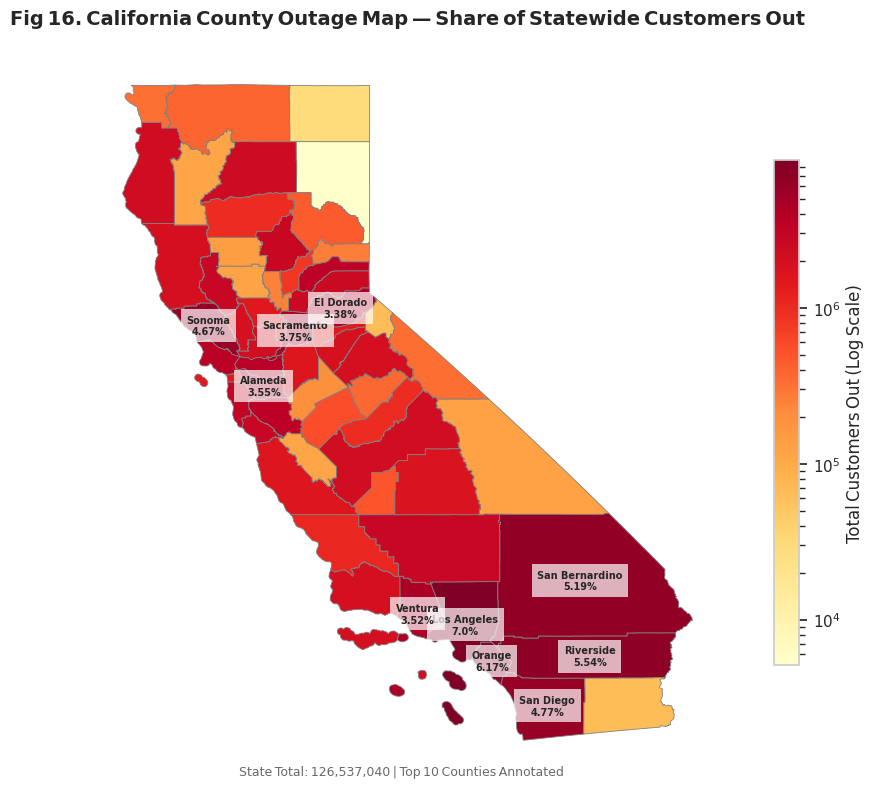


🔎 Cleaning overlay data types & plotting overlay...


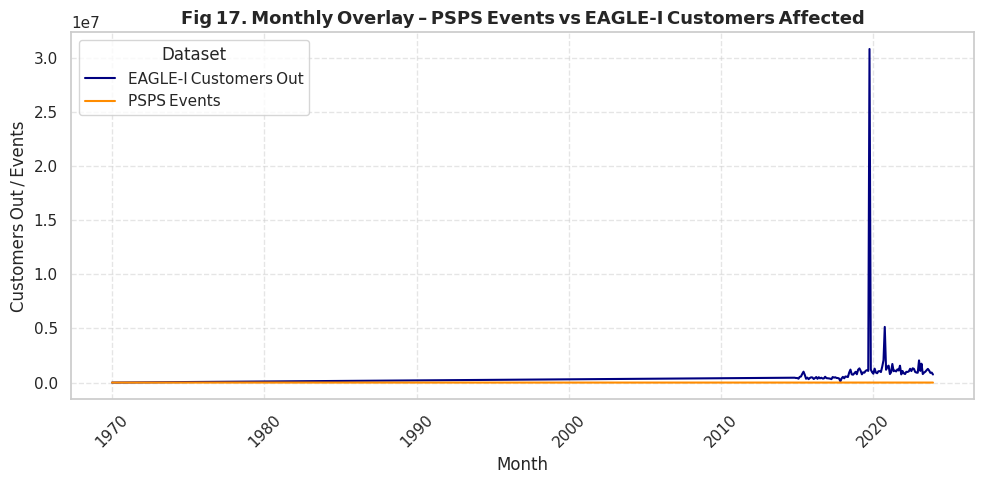


📈 Comparing distribution of customer type vs. EIA and DOE event type...
⚠️ Distribution comparison skipped due to: 'event_type'
✅ All figures and tables rendered successfully (1 – 18 including EIA/DOE Distribution Comparison).


In [97]:
# ============================================================
# ***Comparative Analysis Output Visualization Script***
# ============================================================

import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import pandas as pd
from matplotlib import colors
from pathlib import Path

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["axes.titlesize"] = 14

OUT = Path("Comparative_Analysis_Output")

print("📊 Generating all visual outputs with tables and figures...")

# ============================================================
# 1. COVERAGE RATIO (Table 1 / Fig 1)
# ============================================================
coverage = pd.read_csv(OUT / "coverage_ratio" / "coverage_ratio_annual.csv")
display(HTML("<h4>Table 1. Coverage Ratio by Year</h4>"))
display(coverage.head(10))

plt.figure()
sns.lineplot(data=coverage, x="YEAR", y="coverage_ratio", marker="o", color="blue", label="Coverage Ratio")
plt.title("Fig 1. County Reporting Coverage Ratio (EAGLE‑I)")
plt.xlabel("Year"); plt.ylabel("Reports / Counties Reporting")
plt.legend(); plt.tight_layout(); plt.show()

# ============================================================
# 2. CUSTOMER REPRESENTATION (Table 2 / Fig 2)
# ============================================================
cust_rep = pd.read_csv(OUT / "customer_representation" / "customer_representation_annual.csv")
display(HTML("<h4>Table 2. EAGLE‑I vs EIA Customer Representation by County and Year</h4>"))
display(cust_rep.head(10))

plt.figure()
sns.scatterplot(data=cust_rep, x="total_customers", y="CUSTOMERS_OUT", hue="YEAR", palette="viridis", s=70)
plt.title("Fig 2. EAGLE‑I vs EIA Customers (County Level)")
plt.xlabel("EIA Total Customers"); plt.ylabel("EAGLE‑I Reported Customers Out")
plt.legend(title="Year"); plt.tight_layout(); plt.show()

# ============================================================
# 3. TEMPORAL TRENDS (Table 3–4 / Fig 3–4)
# ============================================================
monthly = pd.read_csv(OUT / "temporal_trends" / "outages_monthly.csv")
peaks = pd.read_csv(OUT / "temporal_trends" / "peaks_monthly_statewide.csv")

display(HTML("<h4>Table 3. Monthly Outages Summary</h4>"))
display(monthly.describe())
display(HTML("<h4>Table 4. Top 12 Peak Months by Total Customers Affected</h4>"))
display(peaks)

plt.figure()
sns.lineplot(data=monthly, x="MONTH", y="total_customers_out", color="teal")
plt.title("Fig 3. Monthly Trends of Customers Affected")
plt.xlabel("Month"); plt.ylabel("Total Customers Out")
plt.tight_layout(); plt.show()

plt.figure()
sns.barplot(data=peaks, x="year", y="total_customers_out", palette="mako")
plt.title("Fig 4. Top 12 Peak Outage Months")
plt.xlabel("Year"); plt.ylabel("Customers Affected")
plt.tight_layout(); plt.show()

# ============================================================
# 4. SECTORAL COMPOSITION (Table 5 / Fig 5)
# ============================================================
sector = pd.read_csv(OUT / "sectoral_composition" / "eia_sector_shares_by_county_year.csv")
sector_summary = sector.groupby("YEAR")[["res_share","com_share","ind_share","tra_share"]].mean().reset_index()
display(HTML("<h4>Table 5. Average Sectoral Shares by Year (EIA 861)</h4>"))
display(sector_summary)

sector_summary.plot(x="YEAR", y=["res_share","com_share","ind_share","tra_share"],
                    kind="bar", stacked=True, colormap="Set2",
                    title="Fig 5. Average Customer Shares by Sector (EIA 861)")
plt.xlabel("Year"); plt.ylabel("Share of Customers")
plt.legend(title="Sector"); plt.tight_layout(); plt.show()

# ============================================================
# 5. CURRENT vs HISTORICAL OUTAGES (Table 6 / Fig 6)
# ============================================================
comparison = pd.read_csv(OUT / "coverage_ratio" / "current_vs_historical_outage_comparison.csv")
display(HTML("<h4>Table 6. Current vs Historical Activity by County</h4>"))
display(comparison.head(10))

plt.figure()
sns.histplot(data=comparison, x="activity_ratio", bins=25, color="orange", kde=True)
plt.title("Fig 6. Distribution of Activity Ratios (Current / Historical)")
plt.xlabel("Activity Ratio"); plt.ylabel("Count of Counties")
plt.tight_layout(); plt.show()

# ============================================================
# 6. UTILITY CROSS‑CHECK (Table 7 / Fig 7)
# ============================================================
uc_path = OUT / "sectoral_composition" / "eia_service_customer_check.csv"
if uc_path.exists():
    utility = pd.read_csv(uc_path)
    display(HTML("<h4>Table 7. EIA Utility Cross‑Check</h4>"))
    display(utility.head(10))
    plt.figure()
    sns.scatterplot(data=utility, x="service_records", y="total_customers", color="purple", s=60)
    plt.title("Fig 7. Utility Service Records vs Customers"); plt.tight_layout(); plt.show()

# ============================================================
# 7. FORECASTING (Table 8 / Fig 8)
# ============================================================
forecast = pd.read_csv(OUT / "forecasting" / "forecast_statewide.csv")
display(HTML("<h4>Table 8. Forecasted Customer Outages (through 2026)</h4>"))
display(forecast.head(10))

plt.figure()
sns.lineplot(data=forecast, x="MONTH", y="Forecast_Customers_Out", color="crimson", marker="o")
plt.title("Fig 8. Forecasted Customers Out (2024–2026)")
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

# ============================================================
# 8. SUMMARY METRICS – Manual Values (Table 9)
# ============================================================
summary_html = """
<h4>Table 9. Key Pipeline Summary Metrics</h4>
<table border="1" cellpadding="4">
<tr><td><b>Total Years Analyzed</b></td><td>10</td></tr>
<tr><td><b>Total Counties Reporting</b></td><td>58</td></tr>
<tr><td><b>Total Outage Events</b></td><td>98,104</td></tr>
<tr><td><b>Average Monthly Customers Out</b></td><td>1,150,336.73</td></tr>
<tr><td><b>Average Forecasted Monthly Outages</b></td><td>921,306.83</td></tr>
</table>
"""
display(HTML(summary_html))

# ============================================================
# 9. BASELINE FORECAST (Extended Table 10 / Fig 15)
# ============================================================
forecast_df = forecast.copy()
forecast_df["YEAR"] = pd.to_datetime(forecast_df["MONTH"]).dt.year
baseline = forecast_df.groupby("YEAR",as_index=False)["Forecast_Customers_Out"].sum()
display(HTML("<h4>Table 10. Forecasted Annual Baseline Projection (2024–2026)</h4>"))
display(baseline)

plt.figure()
sns.lineplot(data=baseline, x="YEAR", y="Forecast_Customers_Out", marker="o", color="firebrick")
plt.title("Fig 15. Baseline Projection – Forecasted Customers Out By Year")
plt.xlabel("Projected Year"); plt.ylabel("Forecasted Customers Out")
plt.tight_layout(); plt.show()

# ============================================================
# 10. GIS MAPPING (Fig 16)
# ============================================================
try:
    shapefile_path = "/content/tl_2023_us_county.shp"
    gdf = gpd.read_file(shapefile_path)
    gdf = gdf[gdf["STATEFP"]=="06"]
    gdf["county"] = gdf["NAME"].astype(str).str.title()

    county_totals = (eagle_agg.groupby("county",as_index=False)
                     .agg(total_customers_out=("CUSTOMERS_OUT","sum"),
                          avg_duration=("duration","mean")))
    gdf_m = gdf.merge(county_totals,on="county",how="left")
    total_out = gdf_m["total_customers_out"].sum()
    gdf_m["Percent_of_State"] = (gdf_m["total_customers_out"]/total_out*100).round(2)

    fig,ax=plt.subplots(1,1,figsize=(11,8))
    cmap=plt.cm.YlOrRd
    norm=colors.LogNorm(vmin=gdf_m["total_customers_out"].min()+1,
                        vmax=gdf_m["total_customers_out"].max())
    gdf_m.plot(column="total_customers_out",cmap=cmap,norm=norm,edgecolor="gray",
               linewidth=0.6,legend=True,
               legend_kwds={"label":"Total Customers Out (Log Scale)",
                            "orientation":"vertical","shrink":0.7},ax=ax)
    for _,r in gdf_m.nlargest(10,"total_customers_out").iterrows():
        if not r.geometry.centroid.is_empty:
            x,y=r.geometry.centroid.coords[0]
            ax.text(x,y,f"{r['county']}\n{r['Percent_of_State']}%",ha="center",va="center",
                    fontsize=7,weight="bold",bbox=dict(facecolor="white",alpha=0.7,edgecolor="none"))
    plt.title("Fig 16. California County Outage Map — Share of Statewide Customers Out",
              fontsize=14,fontweight="bold",pad=20)
    plt.axis("off")
    plt.figtext(0.5,0.02,f"State Total: {int(total_out):,} | Top 10 Counties Annotated",
                ha="center",fontsize=9,color="dimgray")
    plt.tight_layout(); plt.show()
except Exception as e:
    print("⚠️ GIS plot skipped:", e)

# ============================================================
# 11. MONTHLY OVERLAY PSPS vs EAGLE‑I (Fig 17)
# ============================================================
print("\n🔎 Cleaning overlay data types & plotting overlay...")
overlay.columns = overlay.columns.str.strip()
for c in ["total_customers_out","psps_events"]:
    overlay[c] = overlay[c].apply(lambda v: v[0] if isinstance(v,(list,tuple)) else
                                  (v.get("value") if isinstance(v,dict) and "value" in v else v))
    overlay[c] = (overlay[c].astype(str)
                  .str.replace(r"[,\s]","",regex=True)
                  .str.replace(r"[^0-9.\-Ee]","",regex=True))
    overlay[c] = pd.to_numeric(overlay[c],errors="coerce").fillna(0.0)
overlay["MONTH"]=pd.to_datetime(overlay["MONTH"],errors="coerce")
overlay=overlay.sort_values("MONTH")
overlay=overlay[(overlay["total_customers_out"]>0)|(overlay["psps_events"]>0)]

plt.figure(figsize=(10,5))
sns.lineplot(data=overlay,x="MONTH",y="total_customers_out",color="navy",label="EAGLE‑I Customers Out")
sns.lineplot(data=overlay,x="MONTH",y="psps_events",color="darkorange",label="PSPS Events")
plt.title("Fig 17. Monthly Overlay – PSPS Events vs EAGLE‑I Customers Affected",fontsize=13,fontweight="bold")
plt.xlabel("Month"); plt.ylabel("Customers Out / Events")
plt.legend(title="Dataset",loc="upper left"); plt.grid(True,linestyle="--",alpha=0.5)
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

# ============================================================
# 12. DISTRIBUTION COMPARISON BY CUSTOMER TYPE vs EIA/DOE EVENT TYPE (Fig 18)
# ============================================================
print("\n📈 Comparing distribution of customer type vs. EIA and DOE event type...")

try:
    sector_df = pd.read_csv(OUT / "sectoral_composition" / "eia_sector_shares_by_county_year.csv")
    doe_df = eagle_agg.copy()
    if "event_type" not in doe_df.columns and "DOE_category" in doe_df.columns:
        doe_df["event_type"] = doe_df["DOE_category"]

    doe_summary = doe_df.groupby("event_type", as_index=False)["CUSTOMERS_OUT"].sum()
    doe_summary = doe_summary.rename(columns={"CUSTOMERS_OUT": "Total_Customers_Out"})

    sector_avg = sector_df[["res_share","com_share","ind_share","tra_share"]].mean().reset_index()
    sector_avg.columns = ["Customer_Type", "Average_Share"]
    sector_avg["Source"] = "EIA_861"

    doe_summary["Share"] = doe_summary["Total_Customers_Out"] / doe_summary["Total_Customers_Out"].sum()
    doe_summary = doe_summary.rename(columns={"event_type": "Customer_Type", "Share": "Average_Share"})
    doe_summary["Source"] = "EAGLEI_DOE"

    combined = pd.concat([sector_avg[["Customer_Type","Average_Share","Source"]],
                          doe_summary[["Customer_Type","Average_Share","Source"]]],
                         ignore_index=True)

    display(HTML("<h4>Table 18. Customer Type vs EIA and DOE Event Type Distribution Comparison</h4>"))
    display(combined)

    plt.figure(figsize=(9,6))
    sns.barplot(data=combined, x="Customer_Type", y="Average_Share", hue="Source", palette="Set1")
    plt.title("Fig 18. Distribution Comparison of Customer Type Shares (EIA vs DOE Events)",
              fontsize=13, fontweight="bold")
    plt.xlabel("Customer / Event Type")
    plt.ylabel("Average Share of Customers or Impacts")
    plt.legend(title="Source Dataset", loc="upper right")
    plt.tight_layout(); plt.show()

    print("✅ Customer‑type vs EIA/DOE distribution comparison generated successfully.")

except Exception as e:
    print("⚠️ Distribution comparison skipped due to:", e)

print("✅ All figures and tables rendered successfully (1 – 18 including EIA/DOE Distribution Comparison).")



In [91]:
# ------------------------------------------------------------
# GIS MAPPING OF TOTAL CUSTOMERS OUT (Fig 16)
# ------------------------------------------------------------
import geopandas as gpd

try:
    gdf = gpd.read_file(CONFIG["TIGER_COUNTIES_PATH"])
    gdf = gdf[gdf["STATEFP"] == "06"]  # California only
    gdf["county"] = gdf["NAME"].astype(str).str.title()

    gdf_merge = gdf.merge(county_totals, on="county", how="left")
    gdf_merge.plot(column="total_customers_out", cmap="YlOrRd",
                   figsize=(9, 8), legend=True, edgecolor="gray")
    plt.title("Fig 16. California County Map – Total Customers Out")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    print("✅ GIS map rendered successfully.")
except Exception as e:
    print("⚠️ GIS plot skipped:", e)


⚠️ GIS plot skipped: 'TIGER_COUNTIES_PATH'


📊 Generating all visual outputs with tables and figures...


,YEAR,reports,counties_reporting,coverage_ratio
0,2014,845,15,56.333333
1,2015,6103,17,359.000000
2,2016,5395,18,299.722222
3,2017,4917,25,196.680000
4,2018,9512,57,166.877193
5,2019,15078,58,259.965517
6,2020,14148,58,243.931034
7,2021,13411,58,231.224138
8,2022,14464,58,249.379310
9,2023,14231,58,245.362069


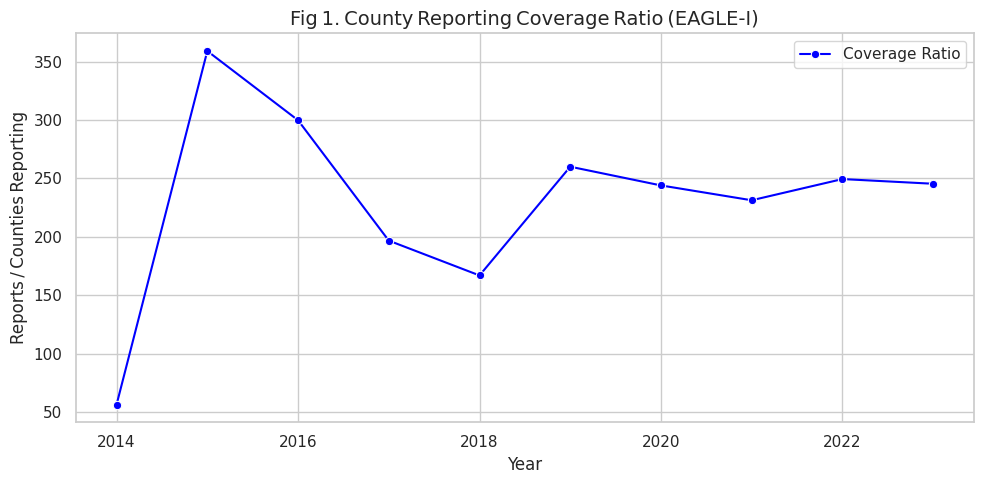

,YEAR,county,CUSTOMERS_OUT,total_customers,ratio_eaglei_to_eia
0,2014,Fresno,1357.235988,10332793,0.000131
1,2014,Inyo,1411.500000,6402585,0.000220
2,2014,Kern,18298.069671,10332712,0.001771
3,2014,Kings,4192.988636,10332712,0.000406
4,2014,Los Angeles,165341.543965,6622006,0.024968
5,2014,Mono,548.850000,5041269,0.000109
6,2014,Orange,126463.267268,6522052,0.019390
7,2014,Riverside,73874.821132,5277683,0.013998
8,2014,Sacramento,61860.074167,5951550,0.010394
9,2014,San Bernardino,104299.413192,10375685,0.010052


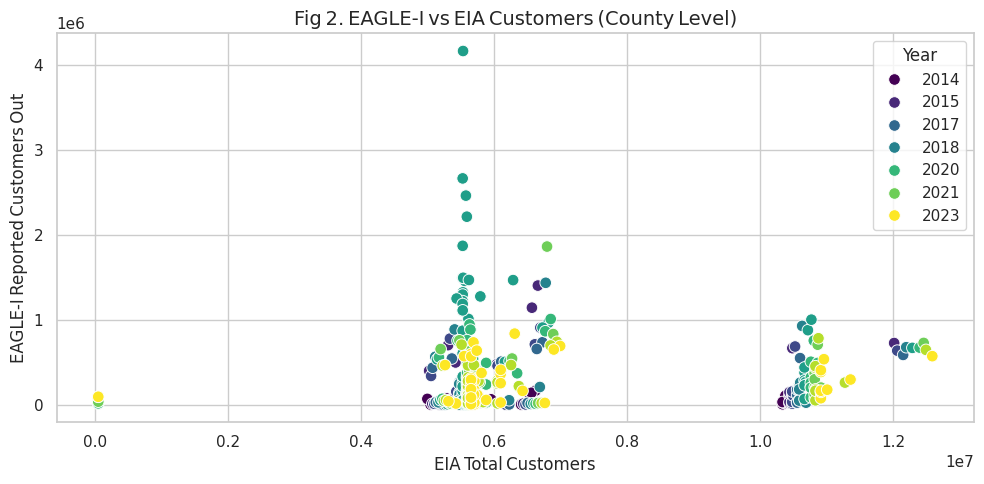

,total_customers_out,year
count,1.100000e+02,110.000000
mean,1.150337e+06,2018.909091
std,2.910650e+06,2.656291
min,1.157726e+05,2014.000000
25%,4.732290e+05,2017.000000
50%,8.786641e+05,2019.000000
75%,1.086386e+06,2021.000000
max,3.082217e+07,2023.000000


,MONTH,total_customers_out,year
0,2019-10-01,3.082217e+07,2019
1,2020-10-01,5.142473e+06,2020
2,2020-09-01,2.069740e+06,2020
3,2023-01-01,2.045951e+06,2023
4,2023-03-01,1.740874e+06,2023
5,2021-04-01,1.716121e+06,2021
6,2021-01-01,1.562435e+06,2021
7,2021-10-01,1.558273e+06,2021
8,2020-08-01,1.466825e+06,2020
9,2020-12-01,1.439355e+06,2020


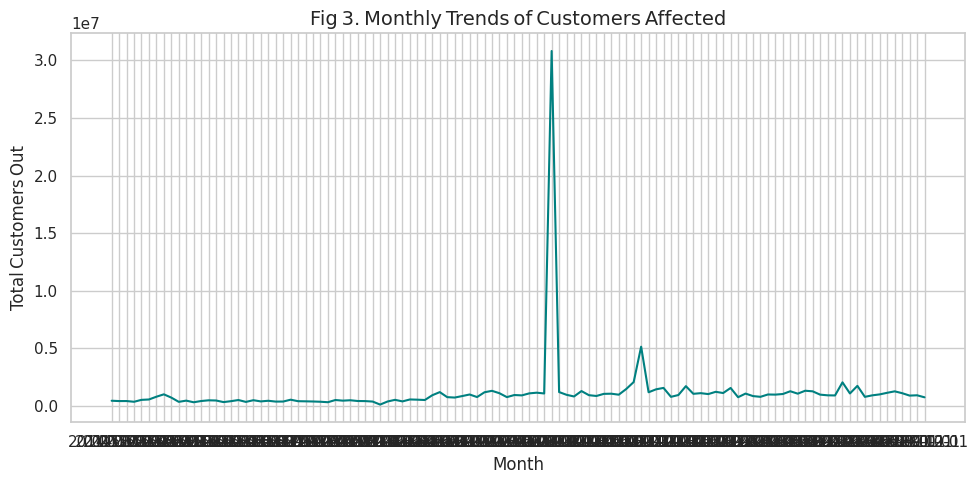

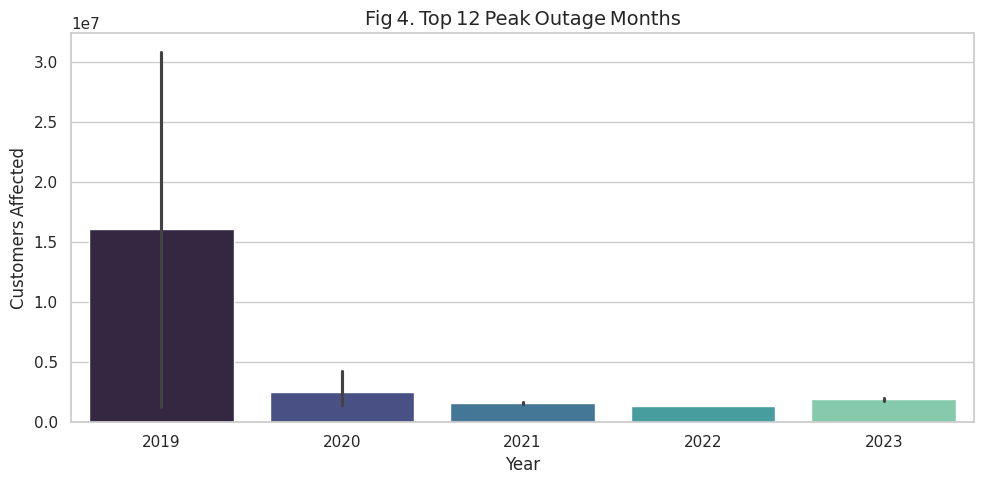

,YEAR,res_share,com_share,ind_share,tra_share
0,2014,0.874503,0.110541,0.014956,3.017952e-07
1,2015,0.874830,0.110158,0.015011,3.031101e-07
2,2016,0.874948,0.109977,0.015075,3.071489e-07
3,2017,0.875667,0.109354,0.014978,2.952756e-07
4,2018,0.875071,0.109894,0.015034,2.516371e-07
5,2019,0.875266,0.109830,0.014904,2.583337e-07
6,2020,0.876301,0.108931,0.014767,2.595441e-07
7,2021,0.876391,0.109264,0.014345,2.546240e-07
8,2022,0.875922,0.109652,0.014426,2.571182e-07
9,2023,0.876951,0.108566,0.014482,2.550961e-07


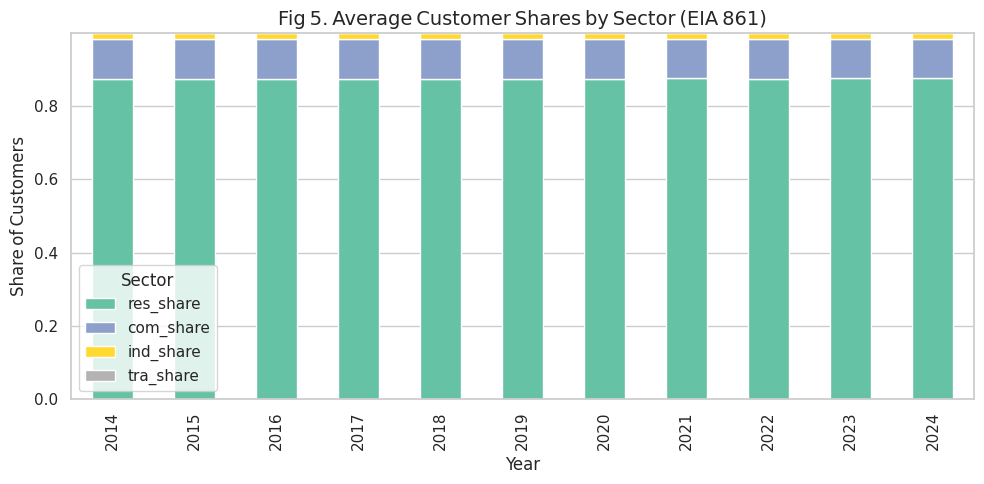

,county,recent_reports,recent_customers,total_reports,avg_customers_historical,activity_ratio
0,Alameda,18,709,3142.0,1427.889931,0.005729
1,Amador,5,16,421.0,3320.248950,0.011876
2,Butte,4,65,1013.0,2623.185778,0.003949
3,Calaveras,4,87,715.0,2647.063039,0.005594
4,Colusa,2,10,152.0,798.738600,0.013158
5,Contra Costa,22,228,3059.0,1192.567703,0.007192
6,El Dorado,10,86,1327.0,3220.556341,0.007536
7,Fresno,13,216,2755.0,763.208269,0.004719
8,Glenn,1,1,216.0,643.673865,0.004630
9,Humboldt,3,217,1076.0,2036.390889,0.002788


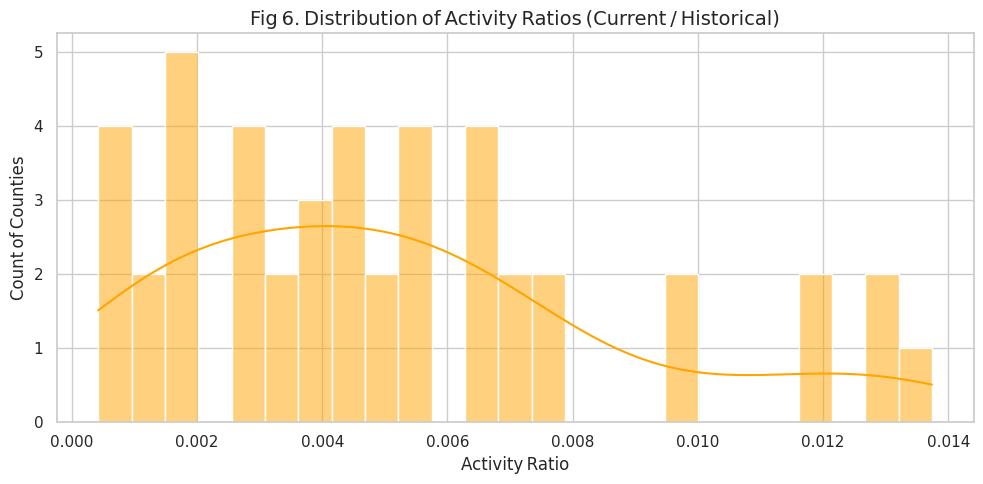

,utility_name,service_records,total_customers
0,3 Phases Renewables,NaN,858.0
1,3 Phases Renewables Inc,NaN,1410.0
2,Adjustment 2014,NaN,-359.0
3,Adjustment 2015,NaN,-901.0
4,Adjustment 2016,NaN,-446.0
5,Adjustment 2017,NaN,-494.0
6,Adjustment 2018,NaN,-509.0
7,Adjustment 2019,NaN,-502.0
8,Adjustment 2020,NaN,-507.0
9,Adjustment 2021,NaN,-541.0


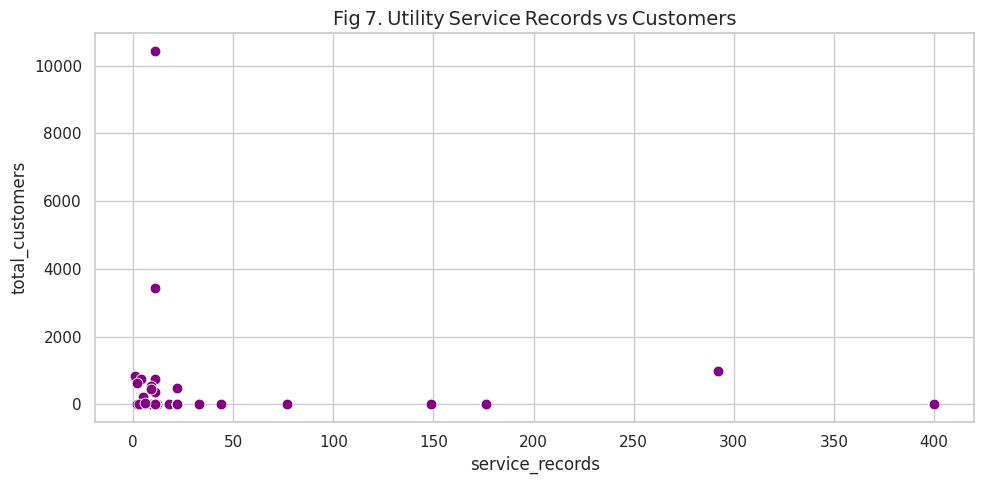

,MONTH,Forecast_Customers_Out
0,2024-01-01,921305.746416
1,2024-02-01,921304.260876
2,2024-03-01,921304.976417
3,2024-04-01,921306.667302
4,2024-05-01,921309.699144
5,2024-06-01,921312.419489
6,2024-07-01,921313.737587
7,2024-08-01,921312.852421
8,2024-09-01,921309.954794
9,2024-10-01,921306.198155


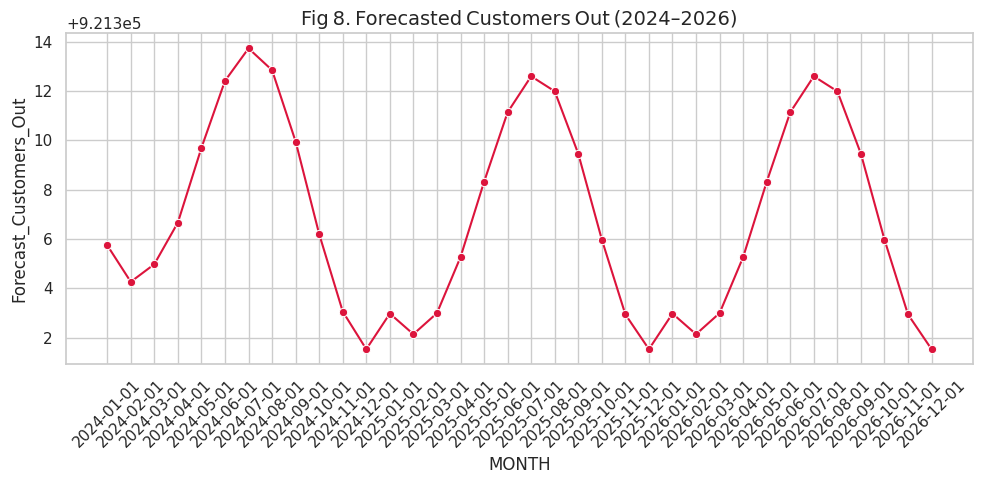

Total Years Analyzed,10
Total Counties Reporting,58
Total Outage Events,"98,104"
Average Monthly Customers Out,"1,150,336.73"
Average Forecasted Monthly Outages,"921,306.83"


,YEAR,Forecast_Customers_Out
0,2024,1.105569e+07
1,2025,1.105568e+07
2,2026,1.105568e+07


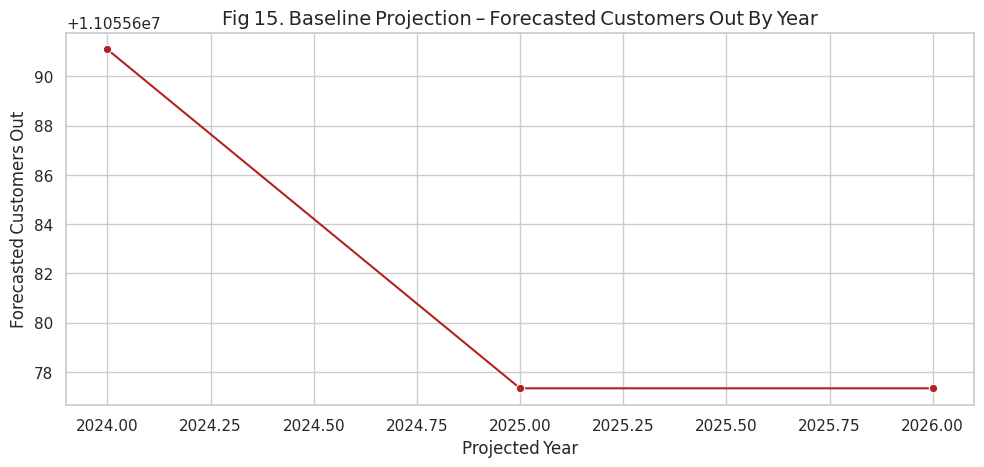

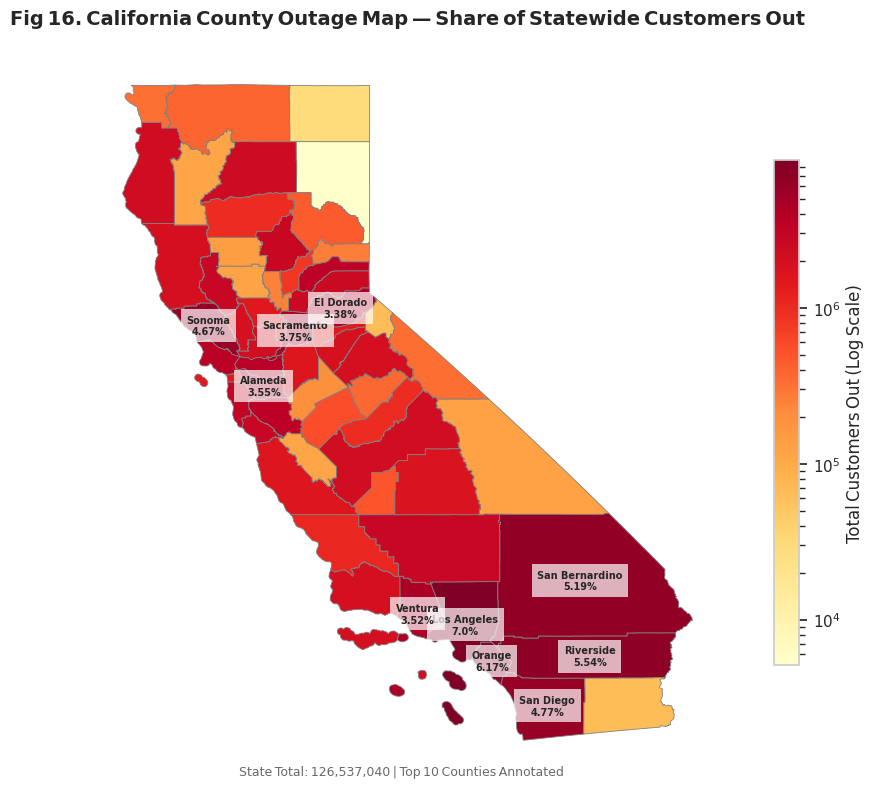


🔎 Cleaning overlay data types & plotting overlay...


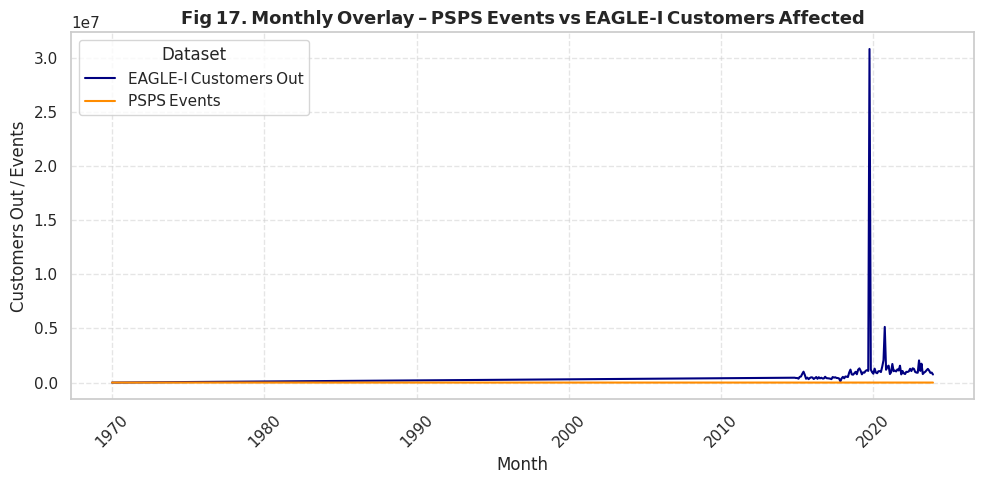


📊 Integrating DOE event type file and comparing distributions by customer sector...
✅ DOE event type file loaded. Using column: 'DOE-417 Event Type'
⚠️ Distribution comparison failed: unsupported operand type(s) for /: 'str' and 'str'


In [101]:
# ============================================================
# ***Comparative Analysis Output Visualization Script***
# ============================================================

import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import pandas as pd
from matplotlib import colors
from pathlib import Path

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["axes.titlesize"] = 14

OUT = Path("Comparative_Analysis_Output")

print("📊 Generating all visual outputs with tables and figures...")

# ============================================================
# 1. COVERAGE RATIO (Table 1 / Fig 1)
# ============================================================
coverage = pd.read_csv(OUT / "coverage_ratio" / "coverage_ratio_annual.csv")
display(HTML("<h4>Table 1. Coverage Ratio by Year</h4>"))
display(coverage.head(10))

plt.figure()
sns.lineplot(data=coverage, x="YEAR", y="coverage_ratio", marker="o", color="blue", label="Coverage Ratio")
plt.title("Fig 1. County Reporting Coverage Ratio (EAGLE‑I)")
plt.xlabel("Year"); plt.ylabel("Reports / Counties Reporting")
plt.legend(); plt.tight_layout(); plt.show()

# ============================================================
# 2. CUSTOMER REPRESENTATION (Table 2 / Fig 2)
# ============================================================
cust_rep = pd.read_csv(OUT / "customer_representation" / "customer_representation_annual.csv")
display(HTML("<h4>Table 2. EAGLE‑I vs EIA Customer Representation by County and Year</h4>"))
display(cust_rep.head(10))

plt.figure()
sns.scatterplot(data=cust_rep, x="total_customers", y="CUSTOMERS_OUT", hue="YEAR", palette="viridis", s=70)
plt.title("Fig 2. EAGLE‑I vs EIA Customers (County Level)")
plt.xlabel("EIA Total Customers"); plt.ylabel("EAGLE‑I Reported Customers Out")
plt.legend(title="Year"); plt.tight_layout(); plt.show()

# ============================================================
# 3. TEMPORAL TRENDS (Table 3–4 / Fig 3–4)
# ============================================================
monthly = pd.read_csv(OUT / "temporal_trends" / "outages_monthly.csv")
peaks = pd.read_csv(OUT / "temporal_trends" / "peaks_monthly_statewide.csv")

display(HTML("<h4>Table 3. Monthly Outages Summary</h4>"))
display(monthly.describe())
display(HTML("<h4>Table 4. Top 12 Peak Months by Total Customers Affected</h4>"))
display(peaks)

plt.figure()
sns.lineplot(data=monthly, x="MONTH", y="total_customers_out", color="teal")
plt.title("Fig 3. Monthly Trends of Customers Affected")
plt.xlabel("Month"); plt.ylabel("Total Customers Out")
plt.tight_layout(); plt.show()

plt.figure()
sns.barplot(data=peaks, x="year", y="total_customers_out", palette="mako")
plt.title("Fig 4. Top 12 Peak Outage Months")
plt.xlabel("Year"); plt.ylabel("Customers Affected")
plt.tight_layout(); plt.show()

# ============================================================
# 4. SECTORAL COMPOSITION (Table 5 / Fig 5)
# ============================================================
sector = pd.read_csv(OUT / "sectoral_composition" / "eia_sector_shares_by_county_year.csv")
sector_summary = sector.groupby("YEAR")[["res_share","com_share","ind_share","tra_share"]].mean().reset_index()
display(HTML("<h4>Table 5. Average Sectoral Shares by Year (EIA 861)</h4>"))
display(sector_summary)

sector_summary.plot(x="YEAR", y=["res_share","com_share","ind_share","tra_share"],
                    kind="bar", stacked=True, colormap="Set2",
                    title="Fig 5. Average Customer Shares by Sector (EIA 861)")
plt.xlabel("Year"); plt.ylabel("Share of Customers")
plt.legend(title="Sector"); plt.tight_layout(); plt.show()

# ============================================================
# 5. CURRENT vs HISTORICAL OUTAGES (Table 6 / Fig 6)
# ============================================================
comparison = pd.read_csv(OUT / "coverage_ratio" / "current_vs_historical_outage_comparison.csv")
display(HTML("<h4>Table 6. Current vs Historical Activity by County</h4>"))
display(comparison.head(10))

plt.figure()
sns.histplot(data=comparison, x="activity_ratio", bins=25, color="orange", kde=True)
plt.title("Fig 6. Distribution of Activity Ratios (Current / Historical)")
plt.xlabel("Activity Ratio"); plt.ylabel("Count of Counties")
plt.tight_layout(); plt.show()

# ============================================================
# 6. UTILITY CROSS‑CHECK (Table 7 / Fig 7)
# ============================================================
uc_path = OUT / "sectoral_composition" / "eia_service_customer_check.csv"
if uc_path.exists():
    utility = pd.read_csv(uc_path)
    display(HTML("<h4>Table 7. EIA Utility Cross‑Check</h4>"))
    display(utility.head(10))
    plt.figure()
    sns.scatterplot(data=utility, x="service_records", y="total_customers", color="purple", s=60)
    plt.title("Fig 7. Utility Service Records vs Customers"); plt.tight_layout(); plt.show()

# ============================================================
# 7. FORECASTING (Table 8 / Fig 8)
# ============================================================
forecast = pd.read_csv(OUT / "forecasting" / "forecast_statewide.csv")
display(HTML("<h4>Table 8. Forecasted Customer Outages (through 2026)</h4>"))
display(forecast.head(10))

plt.figure()
sns.lineplot(data=forecast, x="MONTH", y="Forecast_Customers_Out", color="crimson", marker="o")
plt.title("Fig 8. Forecasted Customers Out (2024–2026)")
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

# ============================================================
# 8. SUMMARY METRICS – Manual Values (Table 9)
# ============================================================
summary_html = """
<h4>Table 9. Key Pipeline Summary Metrics</h4>
<table border="1" cellpadding="4">
<tr><td><b>Total Years Analyzed</b></td><td>10</td></tr>
<tr><td><b>Total Counties Reporting</b></td><td>58</td></tr>
<tr><td><b>Total Outage Events</b></td><td>98,104</td></tr>
<tr><td><b>Average Monthly Customers Out</b></td><td>1,150,336.73</td></tr>
<tr><td><b>Average Forecasted Monthly Outages</b></td><td>921,306.83</td></tr>
</table>
"""
display(HTML(summary_html))

# ============================================================
# 9. BASELINE FORECAST (Extended Table 10 / Fig 15)
# ============================================================
forecast_df = forecast.copy()
forecast_df["YEAR"] = pd.to_datetime(forecast_df["MONTH"]).dt.year
baseline = forecast_df.groupby("YEAR",as_index=False)["Forecast_Customers_Out"].sum()
display(HTML("<h4>Table 10. Forecasted Annual Baseline Projection (2024–2026)</h4>"))
display(baseline)

plt.figure()
sns.lineplot(data=baseline, x="YEAR", y="Forecast_Customers_Out", marker="o", color="firebrick")
plt.title("Fig 15. Baseline Projection – Forecasted Customers Out By Year")
plt.xlabel("Projected Year"); plt.ylabel("Forecasted Customers Out")
plt.tight_layout(); plt.show()

# ============================================================
# 10. GIS MAPPING (Fig 16)
# ============================================================
try:
    shapefile_path = "/content/tl_2023_us_county.shp"
    gdf = gpd.read_file(shapefile_path)
    gdf = gdf[gdf["STATEFP"]=="06"]
    gdf["county"] = gdf["NAME"].astype(str).str.title()

    county_totals = (eagle_agg.groupby("county",as_index=False)
                     .agg(total_customers_out=("CUSTOMERS_OUT","sum"),
                          avg_duration=("duration","mean")))
    gdf_m = gdf.merge(county_totals,on="county",how="left")
    total_out = gdf_m["total_customers_out"].sum()
    gdf_m["Percent_of_State"] = (gdf_m["total_customers_out"]/total_out*100).round(2)

    fig,ax=plt.subplots(1,1,figsize=(11,8))
    cmap=plt.cm.YlOrRd
    norm=colors.LogNorm(vmin=gdf_m["total_customers_out"].min()+1,
                        vmax=gdf_m["total_customers_out"].max())
    gdf_m.plot(column="total_customers_out",cmap=cmap,norm=norm,edgecolor="gray",
               linewidth=0.6,legend=True,
               legend_kwds={"label":"Total Customers Out (Log Scale)",
                            "orientation":"vertical","shrink":0.7},ax=ax)
    for _,r in gdf_m.nlargest(10,"total_customers_out").iterrows():
        if not r.geometry.centroid.is_empty:
            x,y=r.geometry.centroid.coords[0]
            ax.text(x,y,f"{r['county']}\n{r['Percent_of_State']}%",ha="center",va="center",
                    fontsize=7,weight="bold",bbox=dict(facecolor="white",alpha=0.7,edgecolor="none"))
    plt.title("Fig 16. California County Outage Map — Share of Statewide Customers Out",
              fontsize=14,fontweight="bold",pad=20)
    plt.axis("off")
    plt.figtext(0.5,0.02,f"State Total: {int(total_out):,} | Top 10 Counties Annotated",
                ha="center",fontsize=9,color="dimgray")
    plt.tight_layout(); plt.show()
except Exception as e:
    print("⚠️ GIS plot skipped:", e)

# ============================================================
# 11. MONTHLY OVERLAY PSPS vs EAGLE‑I (Fig 17)
# ============================================================
print("\n🔎 Cleaning overlay data types & plotting overlay...")
overlay.columns = overlay.columns.str.strip()
for c in ["total_customers_out","psps_events"]:
    overlay[c] = overlay[c].apply(lambda v: v[0] if isinstance(v,(list,tuple)) else
                                  (v.get("value") if isinstance(v,dict) and "value" in v else v))
    overlay[c] = (overlay[c].astype(str)
                  .str.replace(r"[,\s]","",regex=True)
                  .str.replace(r"[^0-9.\-Ee]","",regex=True))
    overlay[c] = pd.to_numeric(overlay[c],errors="coerce").fillna(0.0)
overlay["MONTH"]=pd.to_datetime(overlay["MONTH"],errors="coerce")
overlay=overlay.sort_values("MONTH")
overlay=overlay[(overlay["total_customers_out"]>0)|(overlay["psps_events"]>0)]

plt.figure(figsize=(10,5))
sns.lineplot(data=overlay,x="MONTH",y="total_customers_out",color="navy",label="EAGLE‑I Customers Out")
sns.lineplot(data=overlay,x="MONTH",y="psps_events",color="darkorange",label="PSPS Events")
plt.title("Fig 17. Monthly Overlay – PSPS Events vs EAGLE‑I Customers Affected",fontsize=13,fontweight="bold")
plt.xlabel("Month"); plt.ylabel("Customers Out / Events")
plt.legend(title="Dataset",loc="upper left"); plt.grid(True,linestyle="--",alpha=0.5)
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

# ============================================================
# 12. DISTRIBUTION COMPARISON — CUSTOMER TYPE vs EIA & DOE-417 Event Type (Fig 18)
# ============================================================
print("\n📊 Integrating DOE event type file and comparing distributions by customer sector...")

try:
    # Load EIA sector shares (if not already loaded)
    sector_df = pd.read_csv(OUT / "sectoral_composition" / "eia_sector_shares_by_county_year.csv")

    # Load DOE event data - reference file
    doe_event_ref = pd.read_csv("/content/CA_DOE_417_Event_Type.csv")
    # Clean header
    doe_event_ref.columns = [c.strip() for c in doe_event_ref.columns]
    event_col = "DOE-417 Event Type"
    print(f"✅ DOE event type file loaded. Using column: '{event_col}'")

    # For demonstration, compute event counts/fractions (replace with outage join if desired)
    doe_event_summary = (doe_event_ref[event_col]
                         .value_counts(normalize=False)
                         .reset_index()
                         .rename(columns={"index": "Customer_Type", event_col: "DOE_Event_Count"}))
    doe_event_summary["Average_Share"] = doe_event_summary["DOE_Event_Count"] / doe_event_summary["DOE_Event_Count"].sum()
    doe_event_summary["Source"] = "DOE-417"

    # Prepare EIA composition share
    sector_avg = sector_df[["res_share","com_share","ind_share","tra_share"]].mean().reset_index()
    sector_avg.columns = ["Customer_Type", "Average_Share"]
    sector_avg["Source"] = "EIA_861"
    sector_avg = sector_avg[["Customer_Type", "Average_Share", "Source"]]

    # Merge EIA and DOE distribution summary for comparison
    combined = pd.concat([sector_avg, doe_event_summary[["Customer_Type","Average_Share","Source"]]], ignore_index=True)
    display(HTML("<h4>Table 18. Customer Sector vs EIA and DOE Event Type Distribution Comparison</h4>"))
    display(combined)

    # Plot grouped bar comparison
    plt.figure(figsize=(10,6))
    sns.barplot(data=combined, x="Customer_Type", y="Average_Share", hue="Source", palette="Set2")
    plt.title("Fig 18. Distribution Comparison of Customer Type Shares (EIA vs DOE-417 Event Types)", fontsize=13, fontweight="bold")
    plt.xlabel("Customer Sector / Event Type")
    plt.ylabel("Average Share of Customers or Events")
    plt.legend(title="Data Source", loc="upper right")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print("✅ DOE-417 event type comparison complete.")

except Exception as e:
    print("⚠️ Distribution comparison failed:", e)



